# DCGAN 

In [1]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

                                              0.0/313.2 kB ? eta -:--:--
     ---                                   30.7/313.2 kB 445.2 kB/s eta 0:00:01
     -------                               61.4/313.2 kB 550.5 kB/s eta 0:00:01
     ------------------------               204.8/313.2 kB 1.4 MB/s eta 0:00:01
     -------------------------------------- 313.2/313.2 kB 1.9 MB/s eta 0:00:00
  Cloning https://github.com/tensorflow/docs to c:\users\katie\appdata\local\temp\pip-req-build-bx1ueh6_
  Resolved https://github.com/tensorflow/docs to commit e24446b758940871677d6a40cd1fa0f4724194da
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.5.26.9808-py3-none-any.whl size=185058 sha256=3e07b3276359479fbbf53288812fcdef273a9279b70e04680cdf66450a0e1078
  Stored in directory: C:\Users\katie\AppData\Local\Temp\pip-ephem-wheel-cache-mcb40yss\wheels\86\0f\1e\3b62293c8ffd0fd5a4950

  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\katie\AppData\Local\Temp\pip-req-build-bx1ueh6_'


In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time

from IPython import display

## Load Data

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 4s 0us/step


In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5 # normalize the images to [-1, 1]

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [6]:
# Batch and shuffle data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create Model

### Build Generator

The generator uses `tf.keras.layer.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). 
- Start with a `Dense` layer that takes this seed as an input
- Upsample several times until you reach the desired image size of `28 x 28 x 1`
- `tf.keras.layers.LeakyReLU` action in each layer, except the output layer which uses `tanh`.

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

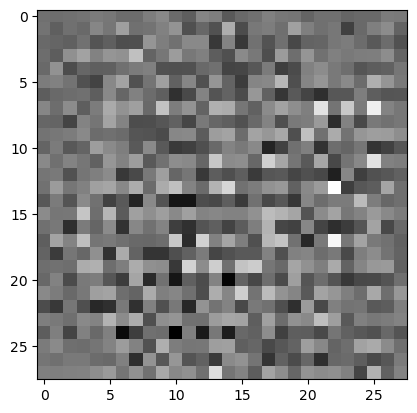

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap="gray")

### Create Discriminator

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]))
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [12]:
discriminator = make_discriminator_model()
decision =  discriminator(generated_image)
print(decision)

tf.Tensor([[0.00190743]], shape=(1, 1), dtype=float32)


### Define the Loss and Optimizers

In [13]:
# this method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator Loss

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator Loss

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save Checkpoints

In [17]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

## Train

In [18]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# you will reuse this seed overtime (so it's easier) to visualize progress in the animated GIF
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss,
                                              generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                   discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
        
        # produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print(f"Time for epoch {epoch + 1} is {time.time() - start} sec.")
        
    # generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [23]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")
        
    plt.savefig(f"image_at_epoch_{epoch}.png")
    plt.show()

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open(f"image_at_epoch_{epoch_no}.png")

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = "dcgan.gif"

with imageio.get_writer(anim_file, mode="I") as writer:
    filenames = glob.glob("image*.png")
    filenames = sorted(filenames)
    
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)